# Self-Driving Car Engineer Nanodegree


## Project 2: **Advanced Lane Lines Finding on the Road** 

##  






## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
import os
%matplotlib inline

## Lane Class Definition

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.averageCnt = 1
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

## Function Definitions

In [3]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Grayscaling input image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate directional gradient
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == "y":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Absolute values and normalizing
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply thresholds
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[np.logical_and(scaled_sobel >= thresh[0], scaled_sobel <= thresh[1])] = 1
    return grad_binary


def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Grayscaling input image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate directional gradient
    xsobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    ysobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Absolute values and normalizing
    magn_sobel = np.sqrt(np.square(xsobel) + np.square(ysobel))
    scaled_magn = np.uint8(255*magn_sobel/np.max(magn_sobel))
    # Apply thresholds
    mag_binary = np.zeros_like(magn_sobel)
    mag_binary[np.logical_and(scaled_magn >= mag_thresh[0], scaled_magn <= mag_thresh[1])] = 1
    return mag_binary


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscaling input image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate directional gradient
    xsobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    ysobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_xsobel = np.absolute(xsobel)
    abs_ysobel = np.absolute(ysobel)
    # Gradient direction and normalization
    direct_sobel = np.arctan2(abs_ysobel, abs_xsobel)
    # Apply thresholds
    dir_binary = np.zeros_like(direct_sobel)
    dir_binary[np.logical_and(direct_sobel >= thresh[0], direct_sobel <= thresh[1])] = 1
    return dir_binary


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty


def search_around_poly(binary_warped, left_fit_prev, right_fit_prev):
    # HYPERPARAMETER
    # Choose the Width of the margin around the previous polynomial to search
    margin = 100
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Search for lane points based on previous poloynomial
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
                    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
                    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
                    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
                    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty
    
    
def fit_polynomial(imgShape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, imgShape[0] - 1, imgShape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx, left_fit, right_fit


# Sanity Check

In [4]:
def sanityCheck(leftLaneFindings, rightLaneFindings):
    #print("---------------------------------------------------")
    #print("DEBUG: Left Lane coeffs mean: ", leftLane.best_fit)
    #print("DEBUG: Average Cnt Left: ", leftLane.averageCnt)
    #print("DEBUG: Right Lane coeffs mean: ", rightLane.best_fit)
    #print("DEBUG: Average Cnt right: ", rightLane.averageCnt)
    
    # Extract information 
    # Left lane
    left_lane_points = leftLaneFindings[0]
    left_lane_poly_coeffs = leftLaneFindings[2]
    left_lane_curvature = leftLaneFindings[1]
    left_lane_pixels = leftLaneFindings[3]
    leftLaneValidity = True
    # Right lane
    right_lane_points = rightLaneFindings[0]
    right_lane_poly_coeffs = rightLaneFindings[2]
    right_lane_curvature = rightLaneFindings[1]
    right_lane_pixels = rightLaneFindings[3]
    rightLaneValidity = True
    
    
    # Check whether this is the first valid frame
    # Left lane
    firstFrameLeft = True
    firstFrameRight = True
    if leftLane.bestx is not None:
        firstFrameLeft = False
    # Right Lane
    if rightLane.bestx is not None: 
        firstFrameRight = False
     # Not enough right lane points available 
    else: 
        rightLane.detected = False
        print("Right Lane not detected: ", len(right_lane_pixels[0]) )
    
    
    # Check whether more than 50 lane points have been identified 
    # This determines whether we use (entire) sliding window approach for the upcoming frame
    # Left Lane
    if len(left_lane_pixels[0]) > 1000:
        leftLane.detected = True
    # Not enough left lane points available    
    else:
        leftLane.detected = False
        print("Left Lane not detected --> Use sliding window: ", len(left_lane_pixels[0]))
    # Right Lane
    if len(right_lane_pixels[0]) > 1000:
        rightLane.detected = True

        
    # Ceck Validity
    # Left Lane
    if firstFrameLeft is not True: 
        # Left Lane Check for average x value
        #x_average_left = sum(left_lane_points)/len(left_lane_points)
        #if abs(x_average_left - leftLane.bestx) > 200: 
        #    leftLaneValidity = False
        #    print("Left Lane average x violation")
        #    print("x_average_left: ", x_average_left)
        #    print("best_x: ", leftLane.bestx )
        # Left Lane check for lane model coefficients deviation
        #leftLaneCoeffsMean = np.mean( np.array([leftLane.best_fit, left_lane_poly_coeffs]), axis=0 )
        #if ((abs(leftLane.best_fit[0] - left_lane_poly_coeffs[0]) > 10e-4) or  
        #     (abs(leftLane.best_fit[1] - left_lane_poly_coeffs[1]) > 5) or 
        #     (abs(leftLane.best_fit[2] - left_lane_poly_coeffs[2]) > 500)):  
        #        print("Left Lane coefficient violation")
        #        print("Current coeffs: ", left_lane_poly_coeffs)
        #        print("Average coeffs: ", leftLane.best_fit )
        #        leftLaneValidity = False
        # Check whether curvature changed too much compared to previous value
        if ((abs(leftLane.current_fit[0] - left_lane_poly_coeffs[0]) > 7e-4) or  
             (abs(leftLane.current_fit[1] - left_lane_poly_coeffs[1]) > 5) or 
             (abs(leftLane.current_fit[2] - left_lane_poly_coeffs[2]) > 300)):  
                print("Left Lane PREVIOUS coefficient violation")
                print("Current coeffs: ", left_lane_poly_coeffs)
                print("Previous coeffs: ", leftLane.current_fit )
                leftLaneValidity = False
        # Check curvature value
        if (abs(left_lane_poly_coeffs[0]) > 7e-4):
            print("Left Lane polyonom has way to much curvature")
            leftLaneValidity = False
    # Right Lane
    if firstFrameRight is not True:
        # Right Lane Check for average x value
        #x_average_right = sum(right_lane_points)/len(right_lane_points)
        #if abs(x_average_right - rightLane.bestx) > 200: 
        #    rightLaneValidity = False
        #    print("Right Lane average x violation")
        #    print("x_average_right: ", x_average_right)
        #    print("best_x: ", rightLane.bestx )
        # Right Lane Check for lane model coefficients deviation
        #rightLaneCoeffsMean = np.mean( np.array([rightLane.best_fit, right_lane_poly_coeffs]), axis=0 )
        #if ((abs(rightLane.best_fit[0] - right_lane_poly_coeffs[0]) > 10e-4) or  
        #   (abs(rightLane.best_fit[1] - right_lane_poly_coeffs[1]) > 5) or 
        #   (abs(rightLane.best_fit[2] - right_lane_poly_coeffs[2]) > 500)):  
        #        print("Right Lane coefficient violation")
        #        print("Current coeffs: ", right_lane_poly_coeffs)
        #        print("Average coeffs: ", rightLane.best_fit)
        #        rightLaneValidity = False
        # Check whether curvature changed too much compared to previous value
        if ((abs(rightLane.best_fit[0] - right_lane_poly_coeffs[0]) > 7e-4) or  
           (abs(rightLane.best_fit[1] - right_lane_poly_coeffs[1]) > 5) or 
           (abs(rightLane.best_fit[2] - right_lane_poly_coeffs[2]) > 300)):  
                print("Right Lane PREVIOUS coefficient violation")
                print("Current coeffs: ", right_lane_poly_coeffs)
                print("Previous coeffs: ", rightLane.current_fit)
                rightLaneValidity = False
        # Check curvature value
        if (abs(right_lane_poly_coeffs[0]) > 7e-4):
            print("Right Lane polynom has way to much curvature")
            leftLaneValidity = False
    
    # If findings make sense and there were enough lane pixels identified, 
    # update the respective lane class with current information
    # Otherwise, use averaged information
    # Left Lane
    if leftLaneValidity == True and leftLane.detected == True: 
        leftLane.averageCnt += 1
        leftLane.recent_xfitted = left_lane_points
        leftLane.current_fit = left_lane_poly_coeffs
        leftLane.radius_of_curvature = left_lane_curvature
        leftLane.line_base_pos = imageShape[0]/2*(3.7/700) - left_lane_points[-1]*(3.7/700) 
        leftLane.allx = left_lane_pixels[0]
        leftLane.ally = left_lane_pixels[1]
        if firstFrameLeft == False:
            #leftLane.bestx = (leftLane.bestx + sum(leftLane.recent_xfitted)/len(leftLane.recent_xfitted))/2
            leftLane.best_fit = np.mean( np.array([leftLane.best_fit, left_lane_poly_coeffs]), axis=0 )
            #leftLane.best_fit = np.array([
            #                        (leftLane.best_fit[0]*leftLane.averageCnt + left_lane_poly_coeffs[0])/(leftLane.averageCnt+1), 
            #                        (leftLane.best_fit[1]*leftLane.averageCnt + left_lane_poly_coeffs[1])/(leftLane.averageCnt+1),
            #                        (leftLane.best_fit[2]*leftLane.averageCnt + left_lane_poly_coeffs[2])/(leftLane.averageCnt+1)   
            #                             ])
        else: 
            leftLane.bestx = sum(leftLane.recent_xfitted)/len(leftLane.recent_xfitted)
            leftLane.best_fit = leftLane.current_fit 
    # Left Lane finding isn´t confident --> Use average information
    # Assumption: Curvature and lane offset doesn´t change compared to previous valid frame
    else:
        print("Use average information for left lane")
        #leftLane.recent_xfitted = leftLane.bestx
        #leftLane.current_fit = leftLane.best_fit
        
    # Right Lane    
    if rightLaneValidity == True and rightLane.detected == True:
        rightLane.averageCnt += 1
        rightLane.recent_xfitted = right_lane_points
        rightLane.current_fit = right_lane_poly_coeffs
        rightLane.radius_of_curvature = right_lane_curvature
        rightLane.line_base_pos = imageShape[0]/2*(3.7/700) - right_lane_points[-1]*(3.7/700) 
        rightLane.allx = right_lane_pixels[0]
        rightLane.ally = right_lane_pixels[1]
        if firstFrameRight == False: 
            rightLane.bestx = (rightLane.bestx + sum(rightLane.recent_xfitted)/len(rightLane.recent_xfitted))/2
            rightLane.best_fit = np.mean( np.array([rightLane.best_fit, right_lane_poly_coeffs]), axis=0 )
            #rightLane.best_fit = np.array([
            #                        (rightLane.best_fit[0]*rightLane.averageCnt + right_lane_poly_coeffs[0])/(rightLane.averageCnt+1), 
            #                        (rightLane.best_fit[1]*rightLane.averageCnt + right_lane_poly_coeffs[1])/(rightLane.averageCnt+1),
            #                        (rightLane.best_fit[2]*rightLane.averageCnt + right_lane_poly_coeffs[2])/(rightLane.averageCnt+1)   
            #                             ])
        else: 
            rightLane.bestx = sum(rightLane.recent_xfitted)/len(rightLane.recent_xfitted)
            rightLane.best_fit = rightLane.current_fit
    # Right Lane finding isn´t confident --> Use average information
    # Assumption: Curvature and lane offset doesn´t change compared to previous valid frame
    else:
        print("Use previous information for right lane")
        #rightLane.recent_xfitted = rightLane.bestx
        #rightLane.current_fit = rightLane.best_fit

# Lane Finding Pipeline

## 0.) Camera calibration

Camera calibartion is not actually an iterative step of the lane line finding pipeline but rather a preprocessing step. The calibration matrix and distortion coefficients are calculated based on the chessboard calibration data (i.e. images) once. Afterwards they are used as static values (data structures) in order to undistort input images when they are passed into the pipeline. The theoretical background behind camera calibration is to learn a camera model which transforms 3D real world points into the 2D camera space. If this transformation model (including distrubances) is known, one can apply the revere transformation in order to undistort the corresponding camera images, i.e. to filter out the distortions. Finding the camera model is done by solving an optimization problem. One aims to find the camera parameters which describes the transformation between known 3D world points and 2D images points best.      

In [5]:
def calibrateCamera(): 
    # Prepare object points and create data structure to store both object points and input points
    # Object points represent the 3D point in the world cos
    # Input points represent the 2D point in the image cos
    # --> 1.) Define number of corners in x and y direction
    nx = 9
    ny = 6
    # --> 2.) Manually define actual corner positions in the real world cos (Assumption: z=0 --> flat plane)
    #         The structure is supposed to be like (x1, y1, z1) in an array format, i.e. [ [1, 1, 0], [2, 1, 0], ... ]
    objp = np.zeros(((nx)*(ny),3), np.float32)
    objp[:,:2] = np.mgrid[1:nx+1,1:ny+1].T.reshape(-1,2)
    # --> 3.) Define the image shape and (empty) lists for both object points and image points
    imageShape = mpimg.imread("camera_cal/calibration1.jpg").shape[1::-1]
    objPoints = []
    imgPoints = []
    # Iterate over calibration images, search for corners and concatenate respective image points"
    calImgsList = os.listdir("camera_cal/")
    for imgName in calImgsList:
        calImg = mpimg.imread("camera_cal/" + imgName)
        gray = cv2.cvtColor(calImg, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True: 
            objPoints.append(objp)
            imgPoints.append(corners)
    # Calibrate the image points against the object points, i.e. calculate the camera model        
    # --> The camera matrix and distortion coefficients can be used later in the pipeline 
    #     to undistort the camera image input(s)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, imageShape, None, None)
    return mtx, dist, imageShape

## 1.) Distortion Correction
Due to the fact that cameras adding some distortion, one has to componsate for these in order to use the actual (i.e. undistorted) image information within the pipeline. That´s why the first step in the lane line finding pipeline is to apply an undistortion filter utilizing the camera model (i.e. camera matrix) and the distortion coefficients. Both the camera model and the distortion coefficients has been acquired in the (offline) calibration step.  

In [6]:
def undistortImage(image, mtx, dist):
    undistImg = cv2.undistort(image, mtx, dist, None, mtx)
    return undistImg

## 2.) Color thresholds
The next step in the pipeline is to use the undistroted image as input and to apply color thresholds which describe yellow and white lanes. Due to lighting and brightnes deviations it´s unfortunate to use RGB thresholding. A more robust solution is to utilize the S (saturation) channel in the HLS color space. The thresholds are manually adapted on the test images.    

## 3.) Gradient based thresholds
Besided applying color thresholds, also gradient based thresholds are promising to identify lanes in the input images. Rather than utilizing knowledge about common colors of lanes, one uses gradient based information in order to laverage the contrast which lane markings have compared to the road. Also one can use the direction in which the corresponding color changes occurs. Like in the color threshold case, the parameters are manually adapted on the test images.    

## 4.) Combining both gradient and color based binary maps
In order to merge the information from both spaces the color and gradient based binary maps are combined using logical OR. 

In [7]:
def applyColorGradientThresholds(image):
    # Apply color threshold on the S channel in the HLS color space
    # --> 1.) Transformation of the undistorted test image to the HLS space and separate the S channel 
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    # --> 2.) Define the color threshold and apply the threshold to the S-channel.
    #         Results, i.e. whether a certain pixel is within (true) or out of (false) the threhold, are stored in a binary map
    colorThresh = (100, 255)
    colorBinary = np.zeros_like(S)
    colorBinary[(S > colorThresh[0]) & (S <= colorThresh[1])] = 1 
    # Apply gradient based thresholds and combine them in order to create a unique gradient based output
    # --> 1.) Gradient magnitude
    magBinary = mag_thresh(image, sobel_kernel=19, mag_thresh=(10, 30))
    # --> 2.) Gradient in x and y direction
    xGradBinary = abs_sobel_thresh(image, orient='x', sobel_kernel=11, thresh=(30, 100))
    yGradBinary = abs_sobel_thresh(image, orient='y', sobel_kernel=19, thresh=(10, 50))
    # --> 3.) Gradient direction
    dirBinary = dir_threshold(image, sobel_kernel=17, thresh=(0.7, 1.3))
    # --> 4.) Combine the above three findings into one single gradient based output
    gradientCombBinary = np.zeros_like(magBinary)
    gradientCombBinary[(xGradBinary==1) & (dirBinary==1)] = 1
    # Combining color and gradient based filtered binary images
    colorGradCombBinary = np.zeros_like(colorBinary)
    colorGradCombBinary[(colorBinary==1) | (gradientCombBinary==1)] = 1
    return colorGradCombBinary

## 5.) Perspective Transform
One crucial part of lane finding is to identify which pixels/points belong to the left and to the right lanes. This task is easier to solve in an transformed perspective, where both lanes appear parallel (like it´s actually the case in the real world). The idea here is to eyeball where the left and right lane would appear in birds eye view. By choosing destination points which cover a rather big area of the image shape, one can "zoom" in a bit, which pretty means nothing by additionaly applying region of interest (ROI). 

In [8]:
def applyBirdsEyeTransform(image):
    # Unwarp image
    leftBottom = (imageShape[1], 190) 
    rightBottom = (imageShape[1], 1120)
    leftTop = (450, 595)
    rightTop = (450, 690)
    leftBottomTarget = (imageShape[1], 300)
    rightBottomTarget = (imageShape[1], 1000)
    leftTopTarget = (0, 300)
    rightTopTarget = (0, 1000)
    src = np.float32([[leftBottom[1], leftBottom[0]], 
                      [leftTop[1], leftTop[0]], 
                      [rightTop[1], rightTop[0]], 
                      [rightBottom[1], rightBottom[0]]])
    dst = np.float32([[leftBottomTarget[1], leftBottomTarget[0]], 
                      [leftTopTarget[1], leftTopTarget[0]], 
                      [rightTopTarget[1], rightTopTarget[0]], 
                      [rightBottomTarget[1], rightBottomTarget[0]]])
    # --> 2.) Calculate the perspective transormation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # --> 3.) Apply the transformation matrix
    warpedImg = cv2.warpPerspective(image, M, imageShape)
    
    return warpedImg, M
    

## 6.) Pixel classification and Polynomial Model fitting 
In this step, we aim to find pixels which corresponds to lane lines. Further, the goal is to identify which pixels belong to the right and left lane. In a first step, one can construct a histogram which counts the pixels upwards in each single column (i.e. along the y-direction) This is done in the lower part of the image, assuming that the lane in fact straight there. The row (i.e the x-position) where the sum of all active (i.e. white) pixels has a max can be considered as lane center point. So, searching for two peaks in the histogram leads to the lane center position for both right and left lane. Using the lane center positions as initial setting, one can further apply a sliding window approach to track the lane along the entire picture.  

In [9]:
def fitLaneModel(image, left_fit_prev = [], right_fit_prev=[], slidingWindow = True):
    # Classify and locate lane points (for left and right lane respectively)
    # There are two options to search for lane points
    # --> 1 Complete search using histogram and sliding window
    # --> 2 Iterative search leveraging previous polyonomial model as region of interest 
    if slidingWindow == True: 
        leftx, lefty, rightx, righty = find_lane_pixels(image)
    else: 
        leftx, lefty, rightx, righty = search_around_poly(image, left_fit_prev, right_fit_prev)
    # Fit a polynomial model to the lane points
    leftLanePoints = [leftx, lefty]
    rightLanePoints = [rightx, righty]
    ploty, left_fitx, right_fitx, left_fit_coeffs, right_fit_coeffs = fit_polynomial(imageShape, leftx, lefty, rightx, righty)
    return ploty, left_fitx, right_fitx, left_fit_coeffs, right_fit_coeffs, leftLanePoints, rightLanePoints

## 7.) Calculating the curvature
Given the polynomial lane models, one can calculate the corresponing radius curvature. 

In [10]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

## 8.) Car Lane Offset
In real life, the car is not always perfectly driving exactly in the middle of the lane. That´s why the information how much the car is shifted might be valuable. Assuming that the camera is mounted in the middle of the car, one can further assume that the actual lane center point is located at the middle of the picture (in x direction). This means, if the car would drive perfectly in the middle of the lane, both lane lines are equally distanced from the image center point.    

In [11]:
def calculate_lane_offset(x_eval_left, x_eval_right):
    # m/pixel 
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # The x-middle of the image (in meter)
    xImgCenterPoint = imageShape[0]/2 * xm_per_pix
    # The actual lane center points (Acquired from the polynomial model)
    leftLaneCenterPoint = x_eval_left*xm_per_pix
    rightLaneCenterPoint = x_eval_right*xm_per_pix
    centerPoint = (leftLaneCenterPoint + rightLaneCenterPoint)/2
    # The deviation between lane center point and image center point measures how much the car shifted away from the lane center
    # Right offset should be considered as positve shift
    laneOffset = centerPoint - xImgCenterPoint
    return laneOffset

## 9.) Transforming results back to the camera (view) space
Classification, lane matching and curvature calculation has been done in the birds eye view space. However, these information has to be projected back into the actual camera space. 

In [12]:
def transformBackToCameraView(image, originalImg, M, left_fitx, right_fitx, ploty, leftLanePixels, rightLanePixels):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Create an image to draw the the lane points on 
    #warp_zero_lane_pixels = np.zeros_like(image).astype(np.uint8)
    #color_warp_lane_pixels = np.dstack((warp_zero_lane_pixels, warp_zero_lane_pixels, warp_zero_lane_pixels))
    #color_warp_lane_pixels[leftLanePixels[1], leftLanePixels[0]] = [255, 0, 0]
    #color_warp_lane_pixels[rightLanePixels[1], rightLanePixels[0]] = [0, 0, 255]
    
    # Combine both in birds eye view space
    #color_warp_combined = cv2.addWeighted(color_warp, 1, color_warp_lane_pixels, 1, 0)
    
    # Invert the camera matrix
    InverseM = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, InverseM, (imageShape[0], imageShape[1])) 
    #newwarp = cv2.warpPerspective(color_warp_combined, InverseM, (imageShape[0], imageShape[1]))   

    # Combine the result with the original image
    result = cv2.addWeighted(originalImg, 1, newwarp, 0.5, 0)
    
    return result

In [13]:
def renderCurvatureAndLaneOffset(image, curvature, laneOffset): 
    text1 = "Curvature: " + str(curvature.round(2))
    text2 = "Lane Offset: " + str(laneOffset.round(2)) + "m"
    textList = [text1, text2]
    for i in range(len(textList)):
        cv2.putText(image, text=textList[i], org=(50,50*(i+1)), fontFace= cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale=1, color=(255,255,255), thickness=3, lineType=cv2.LINE_AA)

# Test on Videos

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [15]:
# Create lane class in order to keep track and filter lane data
leftLane = Line()
rightLane = Line()
leftLane.detected = False
rightLane.detected = False

In [16]:
# Run calibration in order to identify distortion coefficients and camera matrix
cameraModel, distortionCoeffs, imageShape = calibrateCamera()

In [17]:
# Construct lane finding pipeline
def process_image(image):
    # 1 Apply color and gradient based thresholds
    colorGradientFilteredImg = applyColorGradientThresholds(image)
    # 2 Warp image into birds eye view
    warpedImg, M = applyBirdsEyeTransform(colorGradientFilteredImg)
    # 3 Extract the lane points and fit a polyonomial model 
    ploty, left_fitx, right_fitx, left_fit_coeffs, right_fit_coeffs, leftPts, rightPts = fitLaneModel(warpedImg)
    # 4 Calculate curvature and lane offset
    left_curv_real, right_curv_real = measure_curvature_real(ploty, left_fit_coeffs, right_fit_coeffs)
    curvature = (left_curv_real + right_curv_real)/2
    laneOffset = calculate_lane_offset(left_fitx[-1], right_fitx[-1])
    # 5 Render lane area and back transformation to camera view space 
    lanesInImg = transformBackToCameraView(warpedImg, image, M, left_fitx, right_fitx, ploty, leftPts, rightPts)
    # 6 Add curvature and lane center information
    renderCurvatureAndLaneOffset(lanesInImg, curvature, laneOffset)
    return lanesInImg


In [18]:
# Construct lane finding pipeline
def process_image_smooth(image):
    
    # 1 Apply color and gradient based thresholds
    colorGradientFilteredImg = applyColorGradientThresholds(image)
    
    # 2 Warp image into birds eye view
    warpedImg, M = applyBirdsEyeTransform(colorGradientFilteredImg)
    
    # 3 Extract the lane points and fit a polyonomial model
    if leftLane.detected == False and rightLane.detected == False: 
        slidingWindow = True
    else:
        slidingWindow = False
    left_fit_prev = leftLane.current_fit
    right_fit_prev = rightLane.current_fit
    ploty, left_fitx, right_fitx, left_fit_coeffs, right_fit_coeffs, leftPts, rightPts = fitLaneModel(warpedImg, left_fit_prev, right_fit_prev, slidingWindow)
    
    # 4 Calculate curvature and lane offset
    left_curv_real, right_curv_real = measure_curvature_real(ploty, left_fit_coeffs, right_fit_coeffs)
    curvature = (left_curv_real + right_curv_real)/2
    laneOffset = calculate_lane_offset(left_fitx[-1], right_fitx[-1])
    
    # 5 Run sanity check over findings in this particular image and update the lane class information accordingly
    leftLaneFindings = [left_fitx, left_curv_real, left_fit_coeffs, leftPts]
    rightLaneFindings = [right_fitx, right_curv_real, right_fit_coeffs, rightPts]
    sanityCheck(leftLaneFindings, rightLaneFindings)
    
    # 6 Render lane area and back transformation to camera view space 
    # Take information which is tracked in the lane classes
    left_fitx = leftLane.recent_xfitted 
    right_fitx = rightLane.recent_xfitted
    leftPts = leftLane.allx
    rightPts = rightLane.allx
    curvature = (leftLane.radius_of_curvature + rightLane.radius_of_curvature)/2
    laneOffset = calculate_lane_offset(left_fitx[-1], right_fitx[-1])
    
    lanesInImg = transformBackToCameraView(warpedImg, image, M, left_fitx, right_fitx, ploty, leftPts, rightPts)
    
    # 7 Add curvature and lane center information
    renderCurvatureAndLaneOffset(lanesInImg, curvature, laneOffset)
    return lanesInImg


In [19]:
video_output = 'laneFindingVideoOutput.mp4'

#clip = VideoFileClip("project_video.mp4").subclip(0.5)
clip = VideoFileClip("project_video.mp4")
#clip = VideoFileClip("challenge_video.mp4")
#project_clip = clip.fl_image(process_image)
project_clip = clip.fl_image(process_image_smooth) 
%time project_clip.write_videofile(video_output, audio=False)

Right Lane not detected:  14652
[MoviePy] >>>> Building video laneFindingVideoOutput.mp4
[MoviePy] Writing video laneFindingVideoOutput.mp4


  3%|▎         | 33/1261 [00:07<04:43,  4.33it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


  4%|▎         | 45/1261 [00:10<04:37,  4.38it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


  7%|▋         | 84/1261 [00:19<04:33,  4.31it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 14%|█▍        | 175/1261 [00:39<03:56,  4.59it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 14%|█▍        | 176/1261 [00:39<03:57,  4.57it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 14%|█▍        | 177/1261 [00:40<03:58,  4.55it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 14%|█▍        | 178/1261 [00:40<03:59,  4.52it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 14%|█▍        | 179/1261 [00:40<04:02,  4.46it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 14%|█▍        | 180/1261 [00:40<04:03,  4.43it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 14%|█▍        | 181/1261 [00:40<04:04,  4.42it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 14%|█▍        | 182/1261 [00:41<04:04,  4.42it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 15%|█▍        | 185/1261 [00:41<04:02,  4.43it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 15%|█▍        | 186/1261 [00:42<04:00,  4.46it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 15%|█▌        | 191/1261 [00:43<03:55,  4.54it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 15%|█▌        | 193/1261 [00:43<03:55,  4.53it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 15%|█▌        | 194/1261 [00:43<03:54,  4.55it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 16%|█▌        | 196/1261 [00:44<03:56,  4.51it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 19%|█▊        | 236/1261 [00:53<03:46,  4.52it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 19%|█▉        | 237/1261 [00:53<03:46,  4.52it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 19%|█▉        | 238/1261 [00:53<03:43,  4.57it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 20%|█▉        | 246/1261 [00:55<03:45,  4.50it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 20%|█▉        | 247/1261 [00:55<03:44,  4.52it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 21%|██        | 259/1261 [00:58<03:43,  4.48it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 21%|██        | 260/1261 [00:58<03:43,  4.47it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 42%|████▏     | 526/1261 [01:58<02:46,  4.41it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 42%|████▏     | 528/1261 [01:58<02:45,  4.44it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 47%|████▋     | 589/1261 [02:12<02:28,  4.53it/s]

Right Lane PREVIOUS coefficient violation
Current coeffs:  [ 1.11057958e-03 -8.97744183e-01  1.18210211e+03]
Previous coeffs:  [ 4.40160855e-04 -3.53967661e-01  1.07865758e+03]
Right Lane polynom has way to much curvature
Use average information for left lane
Use previous information for right lane


 47%|████▋     | 590/1261 [02:12<02:28,  4.51it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 47%|████▋     | 591/1261 [02:12<02:28,  4.53it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 47%|████▋     | 592/1261 [02:13<02:29,  4.49it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 47%|████▋     | 593/1261 [02:13<02:29,  4.48it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 47%|████▋     | 594/1261 [02:13<02:29,  4.47it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 48%|████▊     | 604/1261 [02:15<02:24,  4.56it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 49%|████▊     | 613/1261 [02:17<02:24,  4.49it/s]

Left Lane polyonom has way to much curvature
Use average information for left lane


 49%|████▊     | 614/1261 [02:18<02:24,  4.47it/s]

Left Lane polyonom has way to much curvature
Use average information for left lane


 49%|████▉     | 615/1261 [02:18<02:27,  4.39it/s]

Left Lane polyonom has way to much curvature
Use average information for left lane


 49%|████▉     | 616/1261 [02:18<02:26,  4.42it/s]

Left Lane polyonom has way to much curvature
Use average information for left lane


 49%|████▉     | 617/1261 [02:18<02:24,  4.45it/s]

Left Lane polyonom has way to much curvature
Use average information for left lane


 49%|████▉     | 618/1261 [02:18<02:23,  4.47it/s]

Left Lane polyonom has way to much curvature
Use average information for left lane


 70%|██████▉   | 882/1261 [03:17<01:23,  4.55it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 80%|███████▉  | 1005/1261 [03:45<00:58,  4.40it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 81%|████████  | 1017/1261 [03:47<00:53,  4.52it/s]

Right Lane polynom has way to much curvature
Use average information for left lane


 81%|████████▏ | 1027/1261 [03:50<00:53,  4.39it/s]

Right Lane PREVIOUS coefficient violation
Current coeffs:  [ 7.18614508e-04 -5.95612661e-01  1.16307328e+03]
Previous coeffs:  [-2.22744576e-04 -1.59872086e-02  1.11728397e+03]
Right Lane polynom has way to much curvature
Use average information for left lane
Use previous information for right lane


 82%|████████▏ | 1028/1261 [03:50<00:53,  4.33it/s]

Right Lane PREVIOUS coefficient violation
Current coeffs:  [ 7.07693639e-04 -6.34978695e-01  1.17317487e+03]
Previous coeffs:  [-2.22744576e-04 -1.59872086e-02  1.11728397e+03]
Right Lane polynom has way to much curvature
Use average information for left lane
Use previous information for right lane


 82%|████████▏ | 1029/1261 [03:50<00:53,  4.37it/s]

Left Lane polyonom has way to much curvature
Right Lane PREVIOUS coefficient violation
Current coeffs:  [ 7.37655049e-04 -6.89710246e-01  1.18499362e+03]
Previous coeffs:  [-2.22744576e-04 -1.59872086e-02  1.11728397e+03]
Right Lane polynom has way to much curvature
Use average information for left lane
Use previous information for right lane


 82%|████████▏ | 1030/1261 [03:50<00:52,  4.37it/s]

Right Lane PREVIOUS coefficient violation
Current coeffs:  [ 7.76662644e-04 -7.25431935e-01  1.19056650e+03]
Previous coeffs:  [-2.22744576e-04 -1.59872086e-02  1.11728397e+03]
Right Lane polynom has way to much curvature
Use average information for left lane
Use previous information for right lane


 82%|████████▏ | 1031/1261 [03:50<00:52,  4.34it/s]

Right Lane PREVIOUS coefficient violation
Current coeffs:  [ 8.79403772e-04 -8.44385498e-01  1.21627458e+03]
Previous coeffs:  [-2.22744576e-04 -1.59872086e-02  1.11728397e+03]
Right Lane polynom has way to much curvature
Use average information for left lane
Use previous information for right lane


 82%|████████▏ | 1032/1261 [03:51<00:52,  4.34it/s]

Right Lane PREVIOUS coefficient violation
Current coeffs:  [ 8.24576439e-04 -8.32086924e-01  1.22276083e+03]
Previous coeffs:  [-2.22744576e-04 -1.59872086e-02  1.11728397e+03]
Right Lane polynom has way to much curvature
Use average information for left lane
Use previous information for right lane


 82%|████████▏ | 1033/1261 [03:51<00:52,  4.30it/s]

Left Lane PREVIOUS coefficient violation
Current coeffs:  [ 5.99325557e-04 -6.60040321e-01  4.64367007e+02]
Previous coeffs:  [-3.22549317e-04  2.42654597e-01  2.58146088e+02]
Right Lane PREVIOUS coefficient violation
Current coeffs:  [ 8.26422181e-04 -8.42064289e-01  1.22816840e+03]
Previous coeffs:  [-2.22744576e-04 -1.59872086e-02  1.11728397e+03]
Right Lane polynom has way to much curvature
Use average information for left lane
Use previous information for right lane


 82%|████████▏ | 1034/1261 [03:51<00:53,  4.27it/s]

Left Lane PREVIOUS coefficient violation
Current coeffs:  [ 7.56325400e-04 -8.41753569e-01  5.19454825e+02]
Previous coeffs:  [-3.22549317e-04  2.42654597e-01  2.58146088e+02]
Left Lane polyonom has way to much curvature
Right Lane PREVIOUS coefficient violation
Current coeffs:  [ 7.73867777e-04 -8.28939272e-01  1.23066136e+03]
Previous coeffs:  [-2.22744576e-04 -1.59872086e-02  1.11728397e+03]
Right Lane polynom has way to much curvature
Use average information for left lane
Use previous information for right lane


 82%|████████▏ | 1035/1261 [03:51<00:52,  4.30it/s]

Left Lane PREVIOUS coefficient violation
Current coeffs:  [ 7.96997061e-04 -9.18649414e-01  5.51814568e+02]
Previous coeffs:  [-3.22549317e-04  2.42654597e-01  2.58146088e+02]
Left Lane polyonom has way to much curvature
Right Lane PREVIOUS coefficient violation
Current coeffs:  [ 6.29401613e-04 -7.05028489e-01  1.21294624e+03]
Previous coeffs:  [-2.22744576e-04 -1.59872086e-02  1.11728397e+03]
Use average information for left lane
Use previous information for right lane


 82%|████████▏ | 1036/1261 [03:52<00:52,  4.30it/s]

Left Lane PREVIOUS coefficient violation
Current coeffs:  [ 1.04653815e-03 -1.18123881e+00  6.21641756e+02]
Previous coeffs:  [-3.22549317e-04  2.42654597e-01  2.58146088e+02]
Left Lane polyonom has way to much curvature
Use average information for left lane


 82%|████████▏ | 1037/1261 [03:52<00:52,  4.25it/s]

Left Lane PREVIOUS coefficient violation
Current coeffs:  [ 8.15266471e-04 -1.00063117e+00  5.96215820e+02]
Previous coeffs:  [-3.22549317e-04  2.42654597e-01  2.58146088e+02]
Left Lane polyonom has way to much curvature
Right Lane polynom has way to much curvature
Use average information for left lane


 82%|████████▏ | 1038/1261 [03:52<00:52,  4.22it/s]

Left Lane PREVIOUS coefficient violation
Current coeffs:  [ 7.11907013e-04 -9.07964785e-01  5.76970506e+02]
Previous coeffs:  [-3.22549317e-04  2.42654597e-01  2.58146088e+02]
Left Lane polyonom has way to much curvature
Right Lane polynom has way to much curvature
Use average information for left lane


 82%|████████▏ | 1039/1261 [03:52<00:52,  4.19it/s]

Left Lane PREVIOUS coefficient violation
Current coeffs:  [ 8.87432377e-04 -1.11408981e+00  6.36583917e+02]
Previous coeffs:  [-3.22549317e-04  2.42654597e-01  2.58146088e+02]
Left Lane polyonom has way to much curvature
Right Lane polynom has way to much curvature
Use average information for left lane


 82%|████████▏ | 1040/1261 [03:53<00:53,  4.16it/s]

Left Lane PREVIOUS coefficient violation
Current coeffs:  [ 5.69416444e-04 -7.82508905e-01  5.53472361e+02]
Previous coeffs:  [-3.22549317e-04  2.42654597e-01  2.58146088e+02]
Right Lane polynom has way to much curvature
Use average information for left lane


100%|█████████▉| 1260/1261 [04:42<00:00,  4.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: laneFindingVideoOutput.mp4 

Wall time: 4min 43s


In [20]:
testImgIndex = 6
testImgList = os.listdir("test_images/") 
testImg = mpimg.imread("test_images/" + testImgList[testImgIndex])
image = testImg

# 1 Apply color and gradient based thresholds
colorGradientFilteredImg = applyColorGradientThresholds(image)

# 2 Warp image into birds eye view
warpedImg, M = applyBirdsEyeTransform(colorGradientFilteredImg)

# 3 Extract the lane points and fit a polyonomial model 
ploty, left_fitx, right_fitx, left_fit_coeffs, right_fit_coeffs, leftPts, rightPts = fitLaneModel(warpedImg)

# 4 Calculate curvature and lane offset
left_curv_real, right_curv_real = measure_curvature_real(ploty, left_fit_coeffs, right_fit_coeffs)
curvature = (left_curv_real + right_curv_real)/2
laneOffset = calculate_lane_offset(left_fitx[-1], right_fitx[-1])

# 5 Render lane area and back transformation to camera view space 
lanesInImg = transformBackToCameraView(warpedImg, image, M, left_fitx, right_fitx, ploty, leftPts, rightPts)

# 6 Add curvature and lane center information
renderCurvatureAndLaneOffset(lanesInImg, curvature, laneOffset)


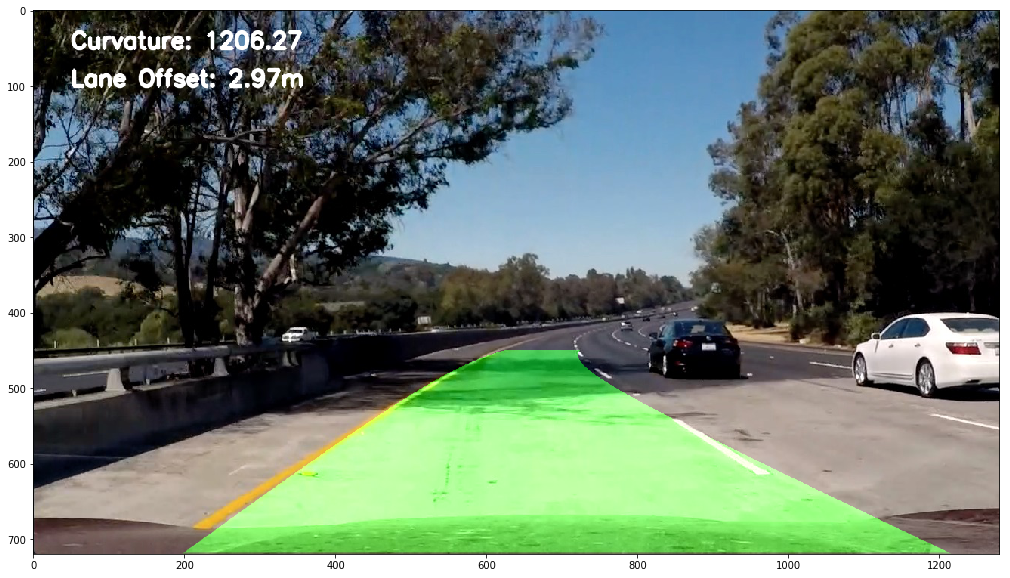

In [21]:
plt.figure(figsize=(20,10))
plt.imshow(lanesInImg); 

In [22]:

array = np.array([1.5, 2.7, 3.2])
array2 = np.array([3.1, 4.3, 5.4])
print(array)
print(array[1])


[1.5 2.7 3.2]
2.7


In [23]:
average = np.mean( np.array([ array, array2 ]), axis=0 )
print(average)
print(type(average))

[2.3 3.5 4.3]
<class 'numpy.ndarray'>


In [24]:
print(abs(3.6-10.2))

6.6


In [25]:
if (False or 
   False or
   True):
    print ("Syntax works")

Syntax works


In [26]:
print(5e-4)

0.0005
